In [1]:
import boto3
import sagemaker

In [2]:
sagemaker_session = sagemaker.session.Session()
role = sagemaker.get_execution_role()

In [3]:
bucket = sagemaker_session.default_bucket()
code_location = f's3://{bucket}/xgboost/code'
output_path = f's3://{bucket}/xgboost/output'

### Define hyperparameter

In [4]:
hyperparameters = {
       "scale_pos_weight" : "29",    
        "max_depth": "3",
        "eta": "0.2",
        "objective": "binary:logistic",
        "num_round": "100",
}

### Cluster Specification

In [5]:
instance_count = 1
instance_type = "ml.m5.large"
#instance_type = "local"
max_run = 1*60*60

use_spot_instances = False
if use_spot_instances:
    max_wait = 1*60*60
else:
    max_wait = None

In [6]:
if instance_type in ['local', 'local_gpu']:
    from sagemaker.local import LocalSession
    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}
else:
    sagemaker_session = sagemaker.session.Session()

### Define training cluster

In [7]:
from sagemaker.xgboost.estimator import XGBoost

estimator = XGBoost(
    entry_point="xgboost_starter_script.py",
    source_dir='src',
    output_path=output_path,
    code_location=code_location,
    hyperparameters=hyperparameters,
    role=role,
    sagemaker_session=sagemaker_session,
    instance_count=instance_count,
    instance_type=instance_type,
    framework_version="1.3-1",
    max_run=max_run,
    use_spot_instances=use_spot_instances,  # spot instance 활용
    max_wait=max_wait,
)

### Prepare training dataset

In [8]:
data_path=f's3://{bucket}/xgboost/dataset'
!aws s3 sync ./data/dataset/ $data_path

In [9]:
if instance_type in ['local', 'local_gpu']:
    from pathlib import Path
    file_path = f'file://{Path.cwd()}'
    inputs = file_path.split('lab_1_training')[0] + '/data/dataset/'
    
else:
    inputs = data_path
inputs

's3://sagemaker-ap-northeast-2-677146750822/xgboost/dataset'

### Define Experiment

In [10]:
!pip install -U sagemaker-experiments

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.


In [11]:
experiment_name='xgb-1'

In [12]:
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from time import strftime

In [13]:
def create_experiment(experiment_name):
    try:
        sm_experiment = Experiment.load(experiment_name)
    except:
        sm_experiment = Experiment.create(experiment_name=experiment_name)
        
def create_trial(experiment_name):
    create_date = strftime("%m%d-%H%M%s")       
    sm_trial = Trial.create(trial_name=f'{experiment_name}-{create_date}',
                            experiment_name=experiment_name)

    job_name = f'{sm_trial.trial_name}'
    return job_name        

### HPO

In [14]:
max_jobs=4    # TODO: Ideally 12 or more
max_parallel_jobs=2   # TODO: Maybe only 1 for Event Engine, 2-3 if possible

In [15]:
create_experiment(experiment_name)
job_name = create_trial(experiment_name)

job_name =  job_name[15:] ## job_name must have length less than or equal to 32 for HPO

tuner = sagemaker.tuner.HyperparameterTuner(
    estimator,
    objective_metric_name="validation:auc",
    hyperparameter_ranges={
        "max_depth": sagemaker.tuner.IntegerParameter(2, 5),
        "eta": sagemaker.tuner.ContinuousParameter(0.1, 0.5)
    },
    objective_type="Maximize",
    max_jobs=max_jobs,    # TODO: Ideally 12 or more
    max_parallel_jobs=max_parallel_jobs,    # TODO: Maybe only 1 for Event Engine, 2-3 if possible
)

tuner.fit(
    job_name = job_name,
    inputs={'inputdata': inputs},
    experiment_config={
          'TrialName': job_name,
          'TrialComponentDisplayName': job_name,
    },
    wait=False
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: 1663496976


In [16]:
tuner.wait()

..................................................................!


### Result

In [17]:
from sagemaker.analytics import ExperimentAnalytics, HyperparameterTuningJobAnalytics
import pandas as pd
pd.options.display.max_columns = 50
pd.options.display.max_rows = 10
pd.options.display.max_colwidth = 100

In [18]:
trial_component_training_analytics = HyperparameterTuningJobAnalytics(
    sagemaker_session= sagemaker_session,
    hyperparameter_tuning_job_name=job_name
)

trial_component_training_analytics.dataframe()[['TrainingJobName', 'TrainingJobStatus', 
                                                'eta', 'max_depth', 'FinalObjectiveValue']]

,TrainingJobName,TrainingJobStatus,eta,max_depth,FinalObjectiveValue
0,1663496976-004-76f1389c,Completed,0.431150,5.0,0.798498
1,1663496976-003-80d5d3d5,Completed,0.319162,5.0,0.799564
2,1663496976-002-4057d2ce,Completed,0.313390,2.0,0.824202
3,1663496976-001-9c089b57,Completed,0.243848,4.0,0.802155


### Evaluation

In [19]:
from sagemaker.processing import FrameworkProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput

In [20]:
instance_count = 1
instance_type = "ml.m5.large"
#instance_type = 'local'

In [21]:
script_eval = FrameworkProcessor(
    XGBoost,
    framework_version="1.3-1",
    role=role,
    instance_type=instance_type,
    instance_count=instance_count
)

INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.m5.large.


In [22]:
client = boto3.client('sagemaker')
response = client.describe_training_job(
    TrainingJobName=tuner.best_training_job()
)

In [23]:
artifacts_dir = response['ModelArtifacts']['S3ModelArtifacts']
artifacts_dir

's3://sagemaker-ap-northeast-2-677146750822/xgboost/output/1663496976-002-4057d2ce/output/model.tar.gz'

In [24]:
s3_test_path = data_path + '/test.csv'
detect_outputpath = f's3://{bucket}/xgboost/processing'

In [25]:
from pathlib import Path
source_dir = f'{Path.cwd()}/src'

if instance_type == 'local':
    from sagemaker.local import LocalSession
    from pathlib import Path

    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}

    s3_test_path=f'../data/dataset/test.csv'
else:
    sagemaker_session = sagemaker.session.Session()
    s3_test_path=data_path + '/test.csv'  

In [26]:
create_experiment(experiment_name)
job_name = create_trial(experiment_name)

script_eval.run(
    code="evaluation.py",
    source_dir=source_dir,
    inputs=[ProcessingInput(source=s3_test_path, input_name="test_data", destination="/opt/ml/processing/test"),
            ProcessingInput(source=artifacts_dir, input_name="model_weight", destination="/opt/ml/processing/model")
    ],
    outputs=[
        ProcessingOutput(source="/opt/ml/processing/output", output_name='evaluation', destination=detect_outputpath + "/" + job_name),
    ],
    job_name=job_name,
    experiment_config={
        'TrialName': job_name,
        'TrialComponentDisplayName': job_name,
    },
    wait=False
)

INFO:sagemaker.processing:Uploaded /home/ec2-user/SageMaker/sg-workshop/src to s3://sagemaker-ap-northeast-2-677146750822/xgb-1-0918-10421663497737/source/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://sagemaker-ap-northeast-2-677146750822/xgb-1-0918-10421663497737/source/runproc.sh
INFO:sagemaker:Creating processing-job with name xgb-1-0918-10421663497737



Job Name:  xgb-1-0918-10421663497737
Inputs:  [{'InputName': 'test_data', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-northeast-2-677146750822/xgboost/dataset/test.csv', 'LocalPath': '/opt/ml/processing/test', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'model_weight', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-northeast-2-677146750822/xgboost/output/1663496976-002-4057d2ce/output/model.tar.gz', 'LocalPath': '/opt/ml/processing/model', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-northeast-2-677146750822/xgb-1-0918-10421663497737/source/sourcedir.tar.gz', 'LocalPath': '/opt/ml/processing/input/code/', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3

In [27]:
script_eval.latest_job.wait()

...........................
#############################################
args.model_path: /opt/ml/processing/model/model.tar.gz
args.test_path: /opt/ml/processing/test/test.csv
args.output_evaluation_dir: /opt/ml/processing/output
****** All folder and files under /opt/ml/processing ****** 
('/opt/ml/processing', ['test', 'output', 'model', 'input'], [])
('/opt/ml/processing/test', [], ['test.csv'])
('/opt/ml/processing/output', [], [])
('/opt/ml/processing/model', [], ['model.tar.gz'])
('/opt/ml/processing/input', ['entrypoint', 'code'], [])
('/opt/ml/processing/input/entrypoint', [], ['runproc.sh'])
('/opt/ml/processing/input/code', ['.ipynb_checkpoints', 'build', 'xgboost_starter_script.egg-info'], ['setup.cfg', 'sourcedir.tar.gz', 'xgboost_starter_script.py', 'setup.py', 'MANIFEST.in', 'evaluation.py'])
('/opt/ml/processing/input/code/.ipynb_checkpoints', [], ['xgboost_starter_script-checkpoint.py', 'evaluation-checkpoint.py'])
('/opt/ml/processing/input/code/build', ['lib', 'bdis

### Check Result

In [28]:
# artifacts_dir = xgb_estimator.model_data.replace('model.tar.gz', '')
print(artifacts_dir)
!aws s3 ls --human-readable {artifacts_dir}

s3://sagemaker-ap-northeast-2-677146750822/xgboost/output/1663496976-002-4057d2ce/output/model.tar.gz
2022-09-18 10:33:27    1.7 KiB model.tar.gz


In [29]:
model_dir = './model'

!rm -rf $model_dir

import json , os

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

!aws s3 cp {artifacts_dir} {model_dir}/model.tar.gz
!tar -xvzf {model_dir}/model.tar.gz -C {model_dir}

download: s3://sagemaker-ap-northeast-2-677146750822/xgboost/output/1663496976-002-4057d2ce/output/model.tar.gz to model/model.tar.gz
xgboost-model


In [30]:
!pip install xgboost graphviz

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.


In [33]:
import xgboost as xgb
import matplotlib.pyplot as plt

model = xgb.XGBClassifier()
model.load_model("./model/xgboost-model")

/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/xgboost/sklearn.py:741: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn(


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

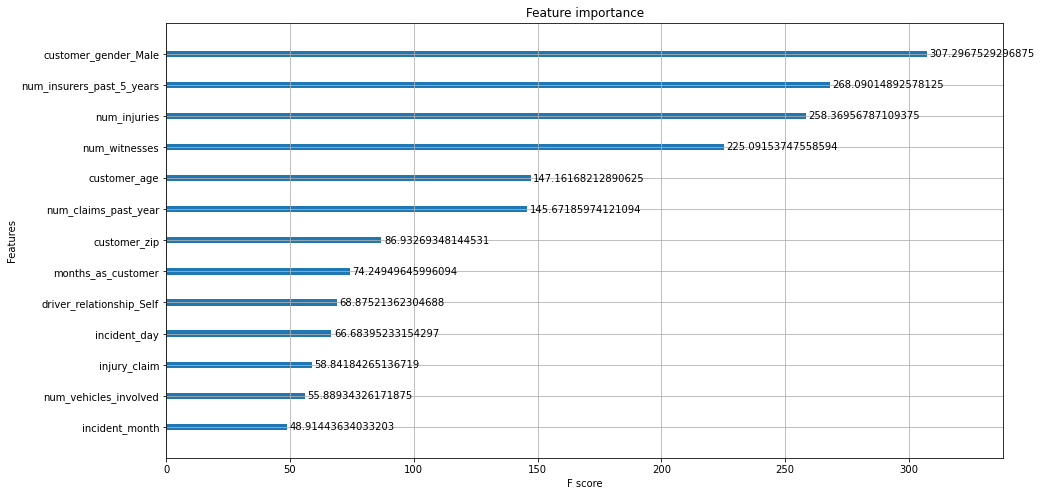

In [34]:
test_prep_df = pd.read_csv('./data/dataset/test.csv')
x_test = test_prep_df.drop('fraud', axis=1)
feature_data = xgb.DMatrix(x_test)
model.get_booster().feature_names = feature_data.feature_names
model.get_booster().feature_types = feature_data.feature_types
fig, ax = plt.subplots(figsize=(15, 8))
xgb.plot_importance(model, ax=ax, importance_type='gain')

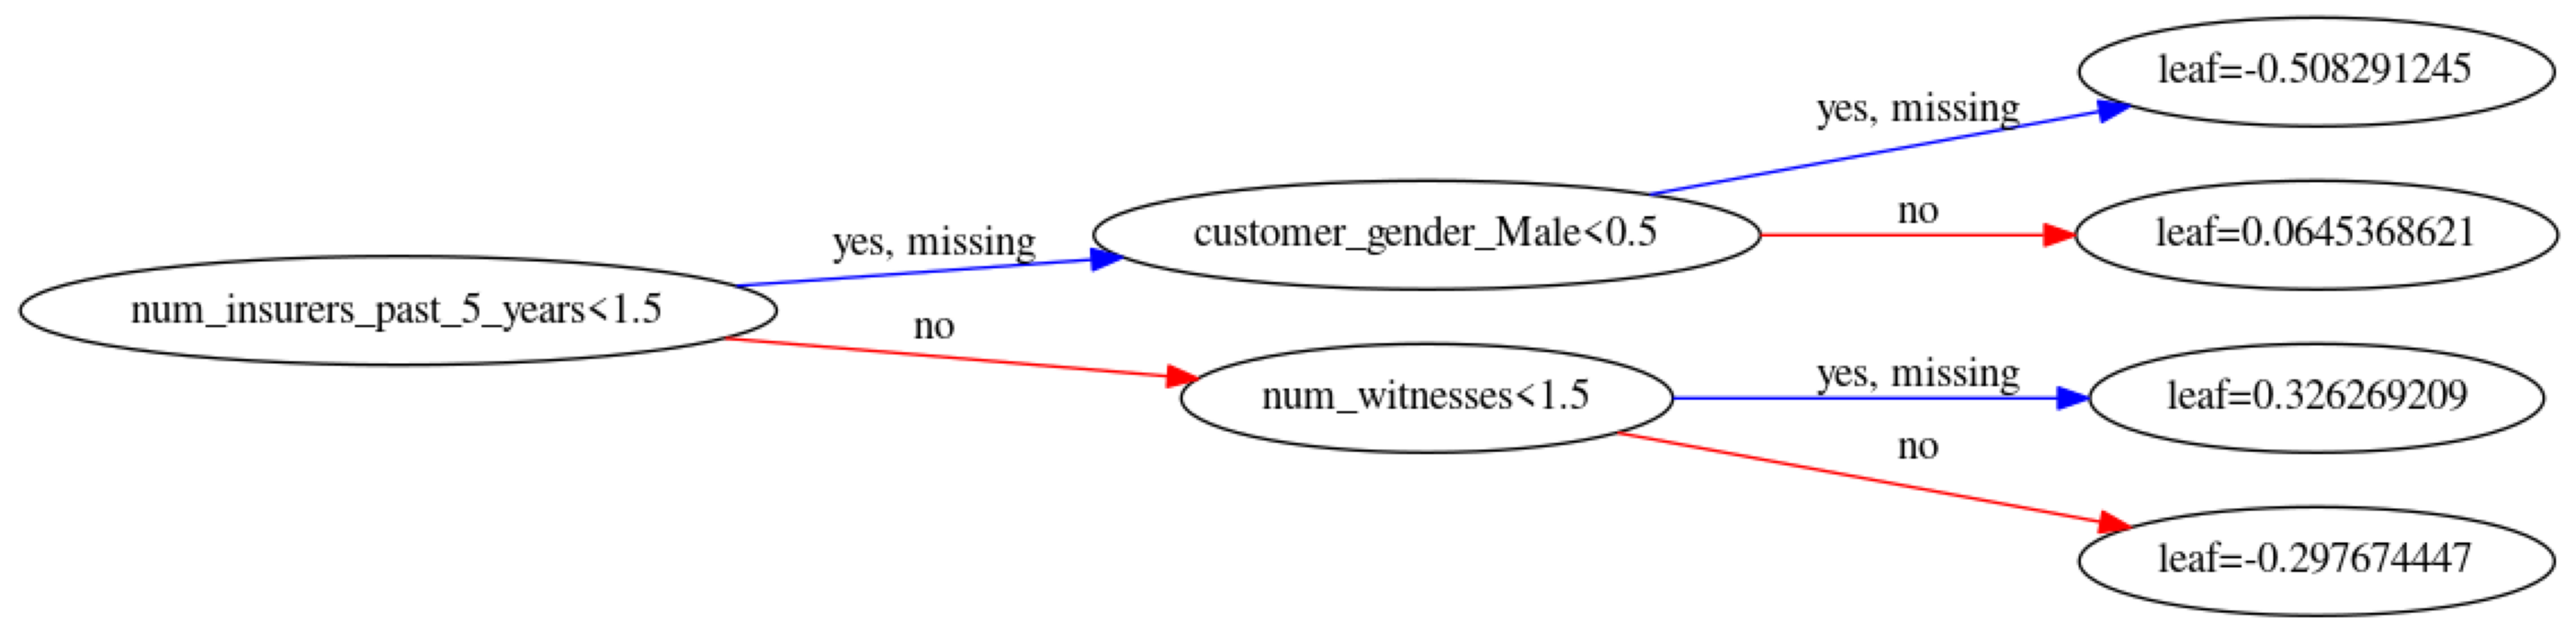

In [35]:
xgb.plot_tree(model, num_trees=0, rankdir='LR')

fig = plt.gcf()
fig.set_size_inches(50, 15)
plt.show()